In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt

np.random.seed(0)

#Загрузка данных

In [2]:
def loading_data(paths):
    #columns = ["Цена за кв.м", "Регион", "Форма проведения", "Жителей в округе",
             #  "Коммерческих объектов", "Жителей h3", "Имущество", "Расстояние до почты", "Этаж"]
    numeric_features = ["Жителей", "Коммерческих объектов", "Расстояние до почты", "Общая площадь"]
    df = pd.DataFrame()
    if type(paths) == list:
        for path in paths:
            df = pd.concat((df, pd.read_excel(path),), axis=0)
    else:
        df = pd.read_excel(paths)
    
    df["Жителей"] = df[["Жителей h3", "Жителей в округе"]].max(axis=1, numeric_only=True)
    df.drop(columns=['Жителей h3', 'Жителей в округе'], axis=1, inplace=True)
    # если жителей в округе 2к значит, точно есть почтовое отделение просто его не смогли найти, не будем учитывать его
    df.loc[((df['Расстояние до почты'].isnull()) & (df["Жителей"] >= 2000)), 'Расстояние до почты'] = 100
    df['Расстояние до почты'].replace(np.nan, 5000, inplace=True)
    df['Коммерческих объектов'].replace(np.nan, 0, inplace=True)
    df['Этаж'].replace(np.nan, 0, inplace=True)
    df['Жителей'].replace('', np.nan, inplace=True)
    df.loc[df["Жителей"] == 'None', "Жителей"] = np.nan
    
    df.dropna(subset=['Жителей'], inplace=True)
    for name in numeric_features:
        df[name].replace(np.nan, 0, inplace=True)
    df["Этаж"].replace(np.nan, 0, inplace=True)
    #df = df.dropna()

    return df

df = loading_data(['../torgi/output_archive.xlsx', '../torgi/output.xlsx'])
print(pd.isnull(df).any())
print(df)

Unnamed: 0                        False
Регион                            False
Общая площадь                     False
id                                False
Название                          False
Окончания подачи заявок           False
Адрес                             False
Цена                              False
Цена за кв.м                      False
H3 чел/кв.м                       False
Чел/кв.м                           True
Ком/кв.м                           True
Коммерческих объектов             False
Расстояние до почты               False
Форма проведения                  False
Имущество                         False
Координаты                        False
Описание коммерческих объектов     True
Кадастровый номер                  True
Этаж                              False
Жителей                           False
dtype: bool
     Unnamed: 0  Регион  Общая площадь                       id  \
0             0       1           52.9   22000066460000000003_1   
1             

<AxesSubplot:title={'center':'Цена за кв.м'}, xlabel='Регион'>

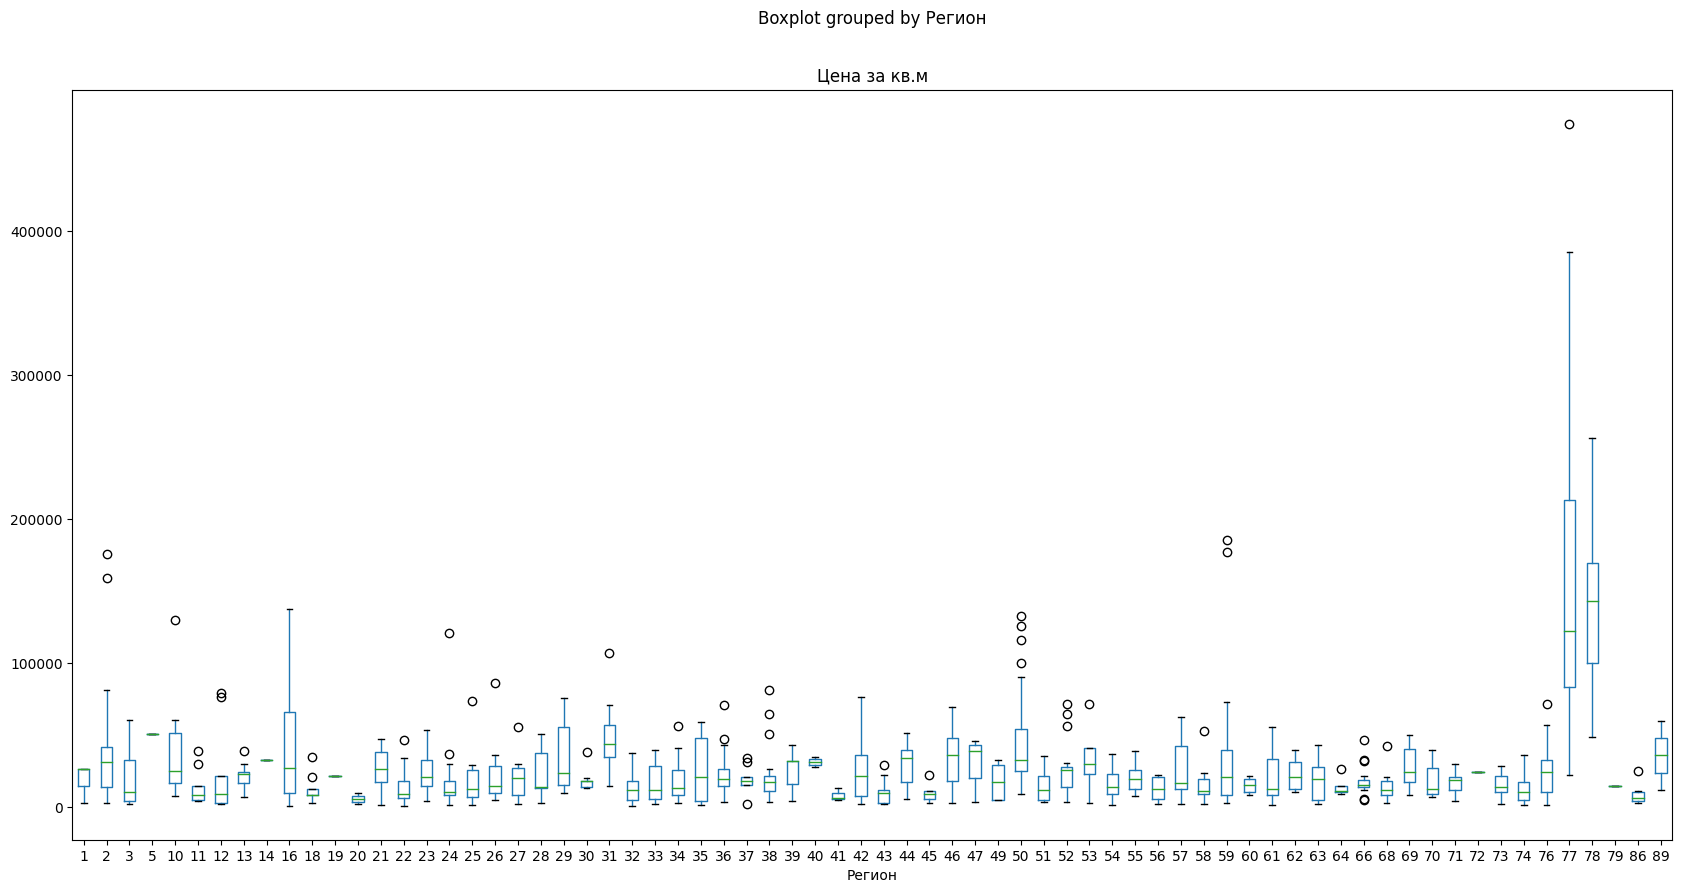

In [3]:
target = "Цена за кв.м"
numeric_features = ["Жителей", "Коммерческих объектов", "Расстояние до почты", "Общая площадь"]
categorical_features = ["Регион", "Форма проведения", "Имущество", "Этаж"]
columns = [target] +numeric_features + categorical_features

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 10)

#смотрим в каких регионах сильный разброс цены за кв.м
df.boxplot(by ='Регион', column =[target], grid = False, figsize=(20,10))

In [4]:
#убираем их из обучения, так как для них нужно обучать свою модель
df = df[~df["Регион"].isin(set([78,77]))]
df.corrwith(df[target])

Unnamed: 0              -0.074088
Регион                  -0.091870
Общая площадь           -0.388911
Цена                     0.238915
Цена за кв.м             1.000000
H3 чел/кв.м              0.171816
Чел/кв.м                 0.003673
Ком/кв.м                 0.148533
Коммерческих объектов    0.295134
Расстояние до почты     -0.179148
Этаж                    -0.043292
Жителей                  0.285551
dtype: float64

<AxesSubplot:>

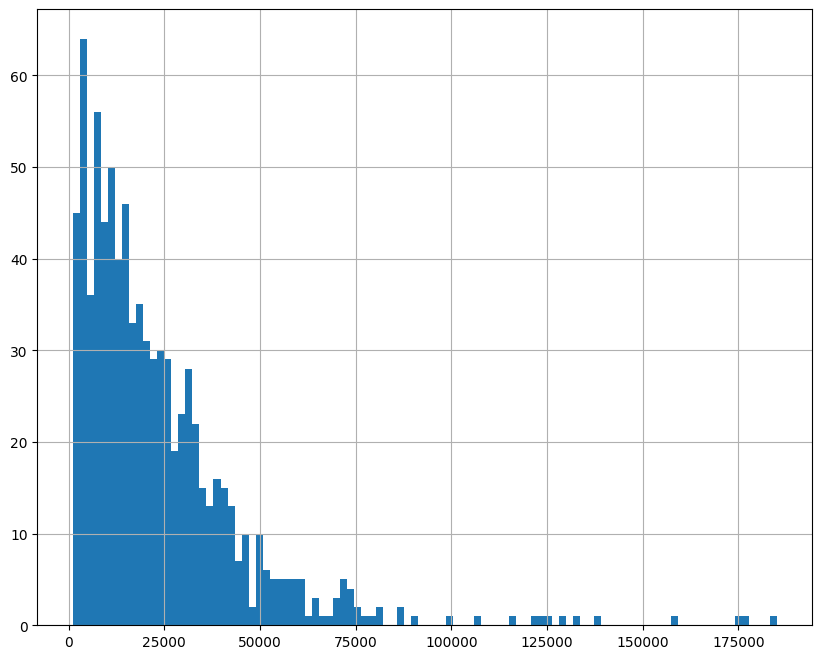

In [5]:
df[target].hist(bins=100, figsize=(10,8))

In [6]:
#удаляем выбросы
def remove_row_emissions(data, row_name):
    print("remove emissions ", row_name)
    lower_bound = data[row_name].quantile(q=0.025)
    upper_bound = data[row_name].quantile(q=0.975)
    #print(data)
    data[(data[row_name] < lower_bound) | (data[row_name] > upper_bound)] = np.nan
    data.dropna(subset=[row_name], inplace=True)

remove_row_emissions(df, "Цена за кв.м")
#remove_row_emissions(df, "Общая площадь")

remove emissions  Цена за кв.м


In [7]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='median')), ("scaler", MinMaxScaler())]
)
#SimpleImputer(strategy='constant', fill_value=1)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", KNeighborsRegressor(8))]
)
#Ridge(alpha=10)
    #model train score: 0.367
    #model test score: 0.300
    #MAE: 10674.231

#KNeighborsRegressor(8)
    #model train score: 0.405
    #model test score: 0.305
    #MAE: 10418.642
#DecisionTreeRegressor(max_depth=4)
    #model train score: 0.435
    #model test score: 0.121
    #MAE: 11433.182

In [8]:
#тренируем модель
y = df["Цена за кв.м"].values
X = df[numeric_features + categorical_features]
#print(X)
df_test = loading_data('../torgi/output_test.xlsx')
df_test = df_test[~df_test["Регион"].isin(set([78,77]))]
remove_row_emissions(df_test, "Цена за кв.м")

y_test = df_test["Цена за кв.м"].values
X_test = df_test[numeric_features + categorical_features]

clf.fit(X, y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# clf.fit(X_train, y_train)

remove emissions  Цена за кв.м


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Жителей',
                                                   'Коммерческих объектов',
                                                   'Расстояние до почты',
                                                   'Общая площадь']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Регион', 'Форма проведения',
                                                   'Имущество', 'Этаж'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=8))])

In [9]:
print("model train score: %.3f" % clf.score(X, y))
print("model test score: %.3f" % clf.score(X_test, y_test))
print("MAE: %.3f" % mean_absolute_error(y_test, clf.predict(X_test)))

model train score: 0.457
model test score: 0.335
MAE: 10822.180


In [10]:
#смотрим результаты

df_test['predicted'] = clf.predict(df_test[numeric_features+categorical_features])
df_test

In [14]:
from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill
def set_predicted_in_xls(file_xlsx_path, df):
    print('set_predicted_in_xls')
    wb = load_workbook(file_xlsx_path)
    ws = wb['Sheet1']
    objs = {}
    objs_by_regions = {}
    for i, row in df.iterrows():
        ws[f'W{int(row[0]) + 2}'].number_format = '_-* # ##0₽_-;-* # ##0₽-'
        ws[f'W{int(row[0]) + 2}'] = row["predicted"]
        
        ws[f'X{int(row[0]) + 2}'].number_format = '_-* # ##0₽_-;-* # ##0₽-'
        ws[f'X{int(row[0]) + 2}'] = row["predicted"]-row["Цена за кв.м"]
        if row["predicted"]-row["Цена за кв.м"] > 1000:
            ws[f'X{int(row[0]) + 2}'].font = font(b=True, font_color='006100')
            ws[f'X{int(row[0]) + 2}'].fill = PatternFill("solid", fgColor="C6EFCE")
        elif row["predicted"]-row["Цена за кв.м"] < 0:
            ws[f'X{int(row[0]) + 2}'].font  = Font(color="9C0006")
            ws[f'X{int(row[0]) + 2}'].fill  = PatternFill(b=True, color="FFC7CE")

    save_opening_output_file(file_xlsx_path)
    wb.save(file_xlsx_path)
    return
from export_to_xlsx import save_opening_output_file
try:
    # что бы можно было оставлять открым файл оутпут
    save_opening_output_file("../torgi/output_test.xlsx")
except Exception as _ex:
    print(_ex)


set_predicted_in_xls("../torgi/output_test.xlsx", df_test)

set_predicted_in_xls


In [15]:
#%pip install -U lightautoml[nlp] -qqqq